# Population In California

In [1]:
import requests
import pandas as pd
import json
import plotly.plotly as py
import plotly.graph_objs as go
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np
#import pandas_datareader.data as web
import urllib
import matplotlib
import numpy as np
import requests
import pandas as pd
from matplotlib import pyplot as plt
import math
from matplotlib import pyplot
import folium
import urllib.request
from bs4 import BeautifulSoup
import statsmodels
import statsmodels.api
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima_model import ARIMA
import plotly.plotly as py
from plotly.graph_objs import *
import plotly
import plotly.graph_objs as go
import warnings
import sys
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import requests_cache
import pandas as pd
from bs4 import BeautifulSoup
import lxml
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import urllib
import plotly.plotly as py
import cufflinks as cf
import plotly.tools as tls

/Users/ricky/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



# Introduction

With the world confronting a host of major crises relating to climate, energy, severe poverty, food, the global economy and political instability, why should anyone be concerned about population? The simple answer is that virtually all of the major problems that confront the world today relate in some critical way to population growth.

While public concern about rapid population growth has subsided in recent decades, world population is still growing at about 80 million people a year, or about 220,000 people per day. If current trends persist, there will 2.5 billion more people on the planet by mid-century, bringing the total to about 9.2 billion. That projected population growth raises a host of questions about the future of humanity and the planet we inhabit.

California, the most populous state in the U.S., happens to be one of the states with higher population growth rate. In this project, we are about to find out how large the population of California will be in the near future and what are some of the factors that contribute to the population migration.

## Why curious about population? 

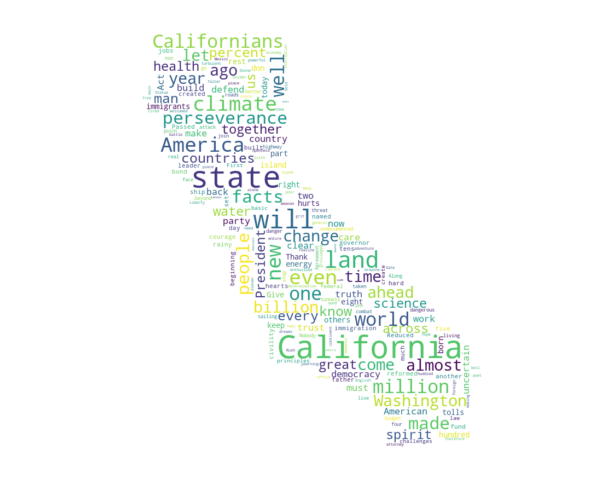

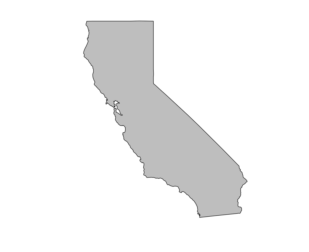

In [4]:
fig, ax = plt.subplots(figsize=(10, 20))
# Read the whole text.
text = open("speech.txt").read()

# read the mask image
california_mask = np.array(Image.open("california.png"))

stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(background_color="white", mask=california_mask,
               stopwords=stopwords)
# generate word cloud
wc.generate(text)

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.imshow(california_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

Based on the WordCloud above, it indicates that people and population are two of the most popular topics in California. 

## Google trend

### Strategy:
Compare the searching interest of specific hot topics in California and that of the population growth rate to identify the similarity in trend between the two.

### Data Summary:
* ggtrend: Google search interest of 'Immigration' overtime
* growth_cal: Population growth rate of California overtime

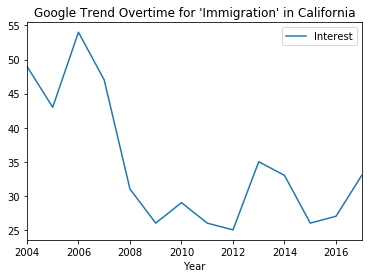

In [5]:
ggtrend = pd.read_csv("GoogleTrend.csv", index_col=0)
ax = ggtrend.plot()
plt.title("Google Trend Overtime for 'Immigration' in California")
plt.show()

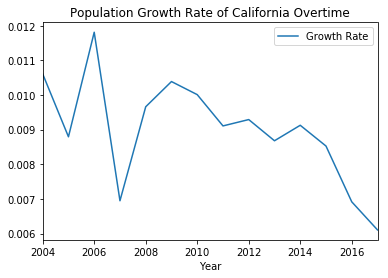

In [6]:
growth_Cal = pd.read_csv("Growth_Cal.csv", index_col=0)
ax = growth_Cal.plot()
plt.title("Population Growth Rate of California Overtime")
plt.show()

### Analysis:
As we can see, although there are some discrepancy between the two graphs in terms of the intensity of the fluctuation, the general trend (in terms of increasing/decreasing year by year) is suprisingly similar. This is a testimony to the power of the online searching in terms of how online search interest change is in sync with the actuality. This analysis further confirms our assumption that population growth rate does change a lot overtime. Now we are about to dig into why and how that happens.

# Methodology

1. Find the useful datas for population and relating factors from the Internet.

2. Fit Time series Model for the population and do the predictions.

3. Use Machine Learning to evaluate the population density and the population distribution. 

4. Use Correlatin Matrix and fit the regression model to analyze factors affectings the population.

5. Investigate the influential factors using visualization and plots. 


# Time series Prediction

### Strategy:
We use time series model to predict the population of CA for 2017-2027. Since we believe that 15 years is a cycle for the population, so we first use the 'first difference' to detrend and then apply the fifteenth difference to deseaonality since we assume the cycle trend is 15. Then we use the function to select the best ARIMA Model by using the BIC criteria.

### Data summary
* Population in thousands of people from 1970 to 2016 from Federal Reserve Economic Data (API)

In [7]:
def pop_search_url(county, verbose = False):
    
    """Search the county information in FRED
    Args:
        county: The county code
        verbose: To detect the error situation
    Returns:
        req.json: JSON object which contains dictionaries and lists
    """
    
    
    url = "https://api.stlouisfed.org/fred/series/observations"
    param = {"series_id" : county,"api_key" : "bb56a8e34d4fe9494d1c16218b1aff87","file_type" : "json"}
    
    response = requests.get(url, param)
    # check for errors
    response.raise_for_status()
    if verbose:
        print(response.url)
    return response.json()

In [8]:
def pop_search(county):
    
    # get the json objects
    items = pop_search_url(county)
    # if error or no results, return empty list
    if "errors" in items:
        return []
    else:
        return items["observations"]

In [9]:
#############################################################################################
# California State time series
capop = pd.DataFrame(pop_search("capop"))
capop2 = capop
capop2["state"] = "California"
capop2["population"] = capop2["value"]
capop3 =capop2[["state","date","population"]]
pivot_ca = capop3.pivot(index='state', columns='date', values='population')

In [10]:
####################################################################################################
# California 58 counties population time series
##### might improve for speed
countylist = pd.read_csv('countylist.csv')

# create a new data frame
df = pd.DataFrame()

for i in range(58):
    countycode = countylist.iloc[i,1]
    county = countylist.iloc[i,0]
    item = pop_search(countycode + 'pop')
    # if no population value collected
    if len(item) == 0:
        x = pd.DataFrame(item)
        x = x.append({'county': county, 'date': 'NA','population': 'NA'}, ignore_index = True)
    else:
        search = pd.DataFrame(item)
        search["county"] = county
        search["population"] = search["value"]
        x = search[['county','date','population']] 
    df = df.append(x)

In [11]:
pop_county = df.pivot(index='county', columns='date', values='population').apply(pd.to_numeric)
pop_county.columns = range(1970,2017)

In [12]:
def TimeSeries(ts_pop, ts_date):
    '''
    Augument: 
        Giving the time series data from the previosu years and predict the population data for next 10 years. 
        
    Input:
        Previous years time series data
        
    Output:
       prediction for the next 10 years
    '''    
    ts_pop = ts_pop.reindex(ts_pop.index[::-1])
    ts_pop.index = ts_date[::-1]
    ts_pop.index = pd.to_datetime(ts_pop.index)
    ts = pd.DataFrame(ts_pop) 
    a = range(0,len(ts['population']))
    ts[0] = a
    pop_value = []
    for i in ts['population']:
        i = float(i)
        pop_value.append(i+1)
    ts['population'] = pop_value
    ts["firstdif"] = ts['population']-ts['population'].shift(-1)
    m = 15
    ts["seasondif"] = ts["firstdif"]-ts["firstdif"].shift(-m) #10 year difference 
    new_date_time = ts.copy()
    del ts['population']
    del ts['firstdif']
    del ts[0]
    ts = ts.dropna(inplace = False)
    res = statsmodels.tsa.stattools.arma_order_select_ic(ts, max_ar=4, max_ma=4, ic='bic', trend='c', model_kw={}, fit_kw={})
    ar = res.bic_min_order[0]
    ma = res.bic_min_order[1]
    model = ARIMA(ts,order = (ar,0,ma))
    model_fit = model.fit(disp = 0)
    forcast = model_fit.forecast(steps = m)[0]
    new_date_time = new_date_time.dropna()
    new_res = []
    new_res_2 = []
    for i in range(0,m):
        new = forcast[i]+new_date_time["firstdif"][-i]
        new_res.append(new)
    tmp = new_res[0]+new_date_time['population'][0]
    new_res_1 = [tmp]
    for i in range(1,m):
          tmp = new_res[i]+tmp
          new_res_1.append(tmp)
    return new_res_1,ar,ma

We choose the 15 most popular counties in CA to analyze. 

In [13]:
df['population'] = pd.to_numeric(df['population'])
sort_pop = df.groupby(['county']).mean().sort_values(by = ['population'], ascending=False)
top15 = sort_pop.head(15)
print(top15)
top15_name = list(top15.index)

                 population
county                     
Los Angeles     8759.451851
Orange          2458.661660
San Diego       2451.416766
Santa Clara     1524.863681
San Bernardino  1436.065426
Alameda         1318.832149
Riverside       1317.220596
Sacramento      1082.325915
Contra Costa     837.371553
San Francisco    750.933660
Fresno           703.071085
Ventura          662.172574
San Mateo        656.944638
Kern             589.910043
San Joaquin      503.703234


We first test the model using the population data from 1970-2005 to predict the population from 2006-2016. And compare the prediction with the real data to see whether my model is valid. 

In [14]:
def ts_pred_15(df, county_name):
    '''
    Input:
        Give the data frame contain population information for all counties
        
    Output:
        the real and predicted populations with residuals for the next 10 years
    '''        
    county_pop = df[df['county']==county_name]['population']
    county_date = df[df['county']==county_name]['date']
    result = TimeSeries(county_pop[0:36], county_date.iloc[0:36])
    real = [float(i) for i in list(county_pop.iloc[37:47])]
    pred = result[0]
    residuals = [a_i - b_i for a_i, b_i in zip(real, pred)]
    return [real,pred,residuals]

In [17]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

top15_res = []
for i in top15_name:    
    top15_res.append(ts_pred_15(df, i))
    

In [16]:
py.sign_in('zhenhansi', 'f1FIXZMElqLq2olEQldG')
plot_date = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
LA = top15_res[0][0]
LA2 = top15_res[0][1]
OR = top15_res[1][0]
OR2 = top15_res[1][1]
SD = top15_res[2][0]
SD2 = top15_res[2][1]
SC = top15_res[3][0]
SC2 = top15_res[3][1]
SB = top15_res[4][0]
SB2 = top15_res[4][1]
AL = top15_res[5][0]
AL2 = top15_res[5][1]
RI = top15_res[6][0]
RI2 = top15_res[6][1]
SA = top15_res[7][0]
SA2 = top15_res[7][1]
CC = top15_res[8][0]
CC2 = top15_res[8][1]
SF = top15_res[9][0]
SF2 = top15_res[9][1]
FR = top15_res[10][0]
FR2 = top15_res[10][1]
VE = top15_res[11][0]
VE2 = top15_res[11][1]
SM = top15_res[12][0]
SM2 = top15_res[12][1]
KR = top15_res[13][0]
KR2 = top15_res[13][1]
SJ = top15_res[14][0]
SJ2 = top15_res[14][1]

trace1 = Scatter(
    x=plot_date, y=LA,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='Los Angeles Real'
)

trace2 = Scatter(
    x=plot_date, y = OR,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='Orange Real'
)


trace3 = Scatter(
    x=plot_date, y=SD,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='San Deigo Real'
)


trace4 = Scatter(
    x=plot_date, y=SC,
    line=Line(
        color='#FFD700',
        width=4
    ),
    name='Santa Clara Real'
)


trace5 = Scatter(
    x=plot_date, y=SB,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='San Bernardino Real'
)

trace6 = Scatter(
    x=plot_date, y = AL,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='Alameda Real'
)


trace7 = Scatter(
    x=plot_date, y=RI,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='Riverside Real'
)


trace8 = Scatter(
    x=plot_date, y=SA,
    line=Line(
        color='#FFD700',
        width=4
    ),
    name='Sacramento Real'
)


trace9 = Scatter(
    x=plot_date, y=CC,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='Contra Costa Real'
)

trace10 = Scatter(
    x=plot_date, y = SF,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='San Francisco Real'
)

trace11 = Scatter(
    x=plot_date, y=FR,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='Fresno Real'
)

trace12 = Scatter(
    x=plot_date, y=VE,
    line=Line(
        color='#FFD700',
        width=4
    ),
    name='Ventura Real'
)

trace13 = Scatter(
    x=plot_date, y=SM,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='San Mateo Real'
)


trace14 = Scatter(
    x=plot_date, y = KR,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='Kern Real'
)

trace15 = Scatter(
    x=plot_date, y=SJ,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='San Joaquin Real'
)

trace16 = Scatter(
    x=plot_date, y = LA2,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='Los Angeles Predict'
)

trace17 = Scatter(
    x=plot_date, y = OR2,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='Orange Predict'
)

trace18 = Scatter(
    x=plot_date, y=SD2,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='San Diego Predict'
)

trace19 = Scatter(
    x=plot_date, y=SC2,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='San Clara Predict'
)

trace20 = Scatter(
    x=plot_date, y = SB2,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='San Bernardino Predict'
)

trace21 = Scatter(
    x=plot_date, y=AL2,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='Alameda Predict'
)

trace22 = Scatter(
    x=plot_date, y=RI2,
    line=Line(
        color='#C0C0C0',
        width=4
    ),
    name='Riverside Predict'
)

trace23 = Scatter(
    x=plot_date, y=SA2,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='Sacremento Predict'
)

trace24 = Scatter(
    x=plot_date, y = CC2,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='Contra Costa Predict'
)

trace25 = Scatter(
    x=plot_date, y=SF2,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='San Francisco Predicr'
)

trace26 = Scatter(
    x=plot_date, y=FR2,
    line=Line(
        color='#C0C0C0',
        width=4
    ),
    name='Fresno Predict'
)

trace27 = Scatter(
    x=plot_date, y=VE2,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='Ventura Predict'
)


trace28 = Scatter(
    x=plot_date, y = SM2,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='San Mateo Predict'
)

trace29 = Scatter(
    x=plot_date, y=KR2,
    line=Line(
        color = '#C0C0C0',
        width=3
    ),
    name='Kern Predict'
)

trace30 = Scatter(
    x=plot_date, y=SJ2,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='San Joaquin Predict'
)


data = Data([trace1, trace2, trace3, trace4,trace5,trace6,trace7,trace8,trace9,trace10,trace11,trace12,trace13,trace14,trace15,trace16,trace17,trace18,trace19,trace20,trace21,trace22,trace23,trace24,trace25,trace26,trace27,trace28,trace29,trace30])

layout = Layout(
    title='The Residuals of Population from 2007 to 2016',
    updatemenus=list([
        dict(
            x=-0.05,
            y=1,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True,False, False, False,False, False, False,False, False, False,False, False, False,False, False,True,False, False, False,False, False, False,False, False, False,False, False, False,False, False]],
                    label='Los_Angeles',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,True, False, False,False, False, False,False, False, False,False, False, False,False, False,False,True, False, False,False, False, False,False, False, False,False, False, False,False, False]],
                    label='Orange',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, True, False,False, False, False,False, False, False,False, False, False,False, False,False,False, True, False,False, False, False,False, False, False,False, False, False,False, False]],
                    label='San_Deigo',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, True,False, False, False,False, False, False,False, False, False,False, False,False,False, False, True,False, False, False,False, False, False,False, False, False,False, False]],
                    label='Santa_Clara',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,True, False, False,False, False, False,False, False, False,False, False,False,False, False, False,True, False, False,False, False, False,False, False, False,False, False]],
                    label='San_Bernardino',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, True, False,False, False, False,False, False, False,False, False,False,False, False, False,False, True, False,False, False, False,False, False, False,False, False]],
                    label='Alameda',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, True,False, False, False,False, False, False,False, False,False,False, False, False,False, False, True,False, False, False,False, False, False,False, False]],
                    label='Riverside',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,True, False, False,False, False, False,False, False,False,False, False, False,False, False, False,True, False, False,False, False, False,False, False]],
                    label='Sacramento',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, True, False,False, False, False,False, False,False,False, False, False,False, False, False,False, True, False,False, False, False,False, False]],
                    label='Contra_Costa',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, True,False, False, False,False, False,False,False, False, False,False, False, False,False, False, True,False, False, False,False, False]],
                    label='San_Francisco',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, False,True, False, False,False, False,False,False, False, False,False, False, False,False, False, False,True, False, False,False, False]],
                    label='Fresno',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, False,False, True, False,False, False,False,False, False, False,False, False, False,False, False, False,False, True, False,False, False]],
                    label='Ventura',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, False,False, False, True,False, False,False,False, False, False,False, False, False,False, False, False,False, False, True,False, False]],
                    label='San Mateo',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, False,False, False, False,True, False,False,False, False, False,False, False, False,False, False, False,False, False, False,True, False]],
                    label='Kern',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, False,False, False, False,False, True,False,False, False, False,False, False, False,False, False, False,False, False, False,False, True]],
                    label='San Joaquin',
                    method='restyle'
                )
                    ]),
        )
    ]),
)
fig = Figure(data=data, layout=layout)
py.iplot(fig)

### Diagnostic
The Grey line of the above plot shows the predict data and the yellow line is the real data. The difference between these two lines are relatively small for most of the counties, note that although some counties looks like thier difference is huge at the first glance, but when you look closely to the y-lable this is a relatively small differences. And we will examine the residual plots following to further prove my model is valie and the data is reliable.
Nest we will make a residual plot to make it more clear. 

In [19]:
py.sign_in('zhenhansi', 'f1FIXZMElqLq2olEQldG')
plot_date = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
LA = top15_res[0][2]
OR = top15_res[1][2]
SD = top15_res[2][2]
SC = top15_res[3][2]
SB = top15_res[4][2]
AL = top15_res[5][2]
RI = top15_res[6][2]
SA = top15_res[7][2]
CC = top15_res[8][2]
SF = top15_res[9][2]
FR = top15_res[10][2]
VE = top15_res[11][2]
SM = top15_res[12][2]
KR = top15_res[13][2]
SJ = top15_res[14][2]

trace1 = Scatter(
    x=plot_date, y=LA,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='Los Angeles'
)


trace2 = Scatter(
    x=plot_date, y = OR,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='Orange'
)

trace3 = Scatter(
    x=plot_date, y=SD,
    line=Line(
        color='#BA8651',
        width=3
    ),
    name='San Deigo'
)

trace4 = Scatter(
    x=plot_date, y=SC,
    line=Line(
        color='#000000',
        width=4
    ),
    name='Santa Clara'
)

trace5 = Scatter(
    x=plot_date, y=SB,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='San Bernardino'
)

trace6 = Scatter(
    x=plot_date, y = AL,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='Alameda'
)

trace7 = Scatter(
    x=plot_date, y=RI,
    line=Line(
        color='#BA8651',
        width=3
    ),
    name='Riverside'
)

trace8 = Scatter(
    x=plot_date, y=SA,
    line=Line(
        color='#000000',
        width=4
    ),
    name='Sacramento'
)

trace9 = Scatter(
    x=plot_date, y=CC,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='Contra Costa'
)

trace10 = Scatter(
    x=plot_date, y = SF,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='San Francisco'
)

trace11 = Scatter(
    x=plot_date, y=FR,
    line=Line(
        color='#BA8651',
        width=3
    ),
    name='Fresno'
)

trace12 = Scatter(
    x=plot_date, y=VE,
    line=Line(
        color='#000000',
        width=4
    ),
    name='Ventura'
)

trace13 = Scatter(
    x=plot_date, y=SM,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='San Mateo'
)


trace14 = Scatter(
    x=plot_date, y = KR,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='Kern'
)

trace15 = Scatter(
    x=plot_date, y=SJ,
    line=Line(
        color='#BA8651',
        width=3
    ),
    name='San Joaquin'
)



data = Data([trace1, trace2, trace3, trace4,trace5,trace6,trace7,trace8,trace9,trace10,trace11,trace12,trace13,trace14,trace15])

layout = Layout(
    title='The Residuals of Population from 2007 to 2016',
    updatemenus=list([
        dict(
            x=-0.05,
            y=1,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True,False, False, False,False, False, False,False, False, False,False, False, False,False, False,False]],
                    label='Los_Angeles',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,True, False, False,False, False, False,False, False, False,False, False, False,False, False,False]],
                    label='Orange',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, True, False,False, False, False,False, False, False,False, False, False,False, False,False]],
                    label='San_Deigo',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, True,False, False, False,False, False, False,False, False, False,False, False,False]],
                    label='Santa_Clara',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,True, False, False,False, False, False,False, False, False,False, False,False]],
                    label='San_Bernardino',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, True, False,False, False, False,False, False, False,False, False,False]],
                    label='Alameda',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, True,False, False, False,False, False, False,False, False,False]],
                    label='Riverside',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,True, False, False,False, False, False,False, False,False]],
                    label='Sacramento',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, True, False,False, False, False,False, False,False]],
                    label='Contra_Costa',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, True,False, False, False,False, False,False]],
                    label='San_Francisco',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, False,True, False, False,False, False,False]],
                    label='Fresno',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, False,False, True, False,False, False,False]],
                    label='Ventura',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, False,False, False, True,False, False,False]],
                    label='San Mateo',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, False,False, False, False,True, False,False]],
                    label='Kern',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, False,False, False, False,False, True,False]],
                    label='San Joaquin',
                    method='restyle'
                )
                    ]),
        )
    ]),
)
fig = Figure(data=data, layout=layout)
py.iplot(fig)

So we can see except for LA all other counties prediction have small residuals comparing the whole population and the prediction is reliable. The big differences to the LA may due to the population increase for LA in the past 30 years are so huge and thus making that prediction error.

# Predict the population for 2017-2026

We use the same arima model tested above to predict the next 10 year's population since we have proved above that my model is valid.

The following plot shows the prediction for population for 2017-2026 for 15 counties in CA. We can see that by the predictions, most counties population keep increasing for the next 10 years.

Moreover, the increase rate in 2020-2022 may seem samller comparing to the other years.

In [20]:
def ts_pred_next(df, county_name):
    '''
    Input:
        Give the data frame contain population information for all counties for all years
        
    Output:
        the predicted population for the next 10 years 
    '''        
    county_pop = df[df['county']==county_name]['population']
    county_date = df[df['county']==county_name]['date']
    result = TimeSeries(county_pop[0:46], county_date.iloc[0:46])
    pred = result[0]
    return pred

In [21]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

top15_pred = []
for i in top15_name:    
    top15_pred.append(ts_pred_next(df, i))

In [22]:
plot_date = ['2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026']
LA = top15_pred[0]
OR = top15_pred[1]
SD = top15_pred[2]
SC = top15_pred[3]
SB = top15_pred[4]
AL = top15_pred[5]
RI = top15_pred[6]
SA = top15_pred[7]
CC = top15_pred[8]
SF = top15_pred[9]
FR = top15_pred[10]
VE = top15_pred[11]
SM = top15_pred[12]
KR = top15_pred[13]
SJ = top15_pred[14]

trace1 = Scatter(
    x=plot_date, y=LA,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='Los Angeles'
)


trace2 = Scatter(
    x=plot_date, y = OR,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='Orange'
)

trace3 = Scatter(
    x=plot_date, y=SD,
    line=Line(
        color='#BA8651',
        width=3
    ),
    name='San Deigo'
)

trace4 = Scatter(
    x=plot_date, y=SC,
    line=Line(
        color='#000000',
        width=4
    ),
    name='Santa Clara'
)

trace5 = Scatter(
    x=plot_date, y=SB,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='San Bernardino'
)

trace6 = Scatter(
    x=plot_date, y = AL,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='Alameda'
)

trace7 = Scatter(
    x=plot_date, y=RI,
    line=Line(
        color='#BA8651',
        width=3
    ),
    name='Riverside'
)

trace8 = Scatter(
    x=plot_date, y=SA,
    line=Line(
        color='#000000',
        width=4
    ),
    name='Sacramento'
)

trace9 = Scatter(
    x=plot_date, y=CC,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='Contra Costa'
)

trace10 = Scatter(
    x=plot_date, y = SF,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='San Francisco'
)

trace11 = Scatter(
    x=plot_date, y=FR,
    line=Line(
        color='#BA8651',
        width=3
    ),
    name='Fresno'
)

trace12 = Scatter(
    x=plot_date, y=VE,
    line=Line(
        color='#000000',
        width=4
    ),
    name='Ventura'
)

trace13 = Scatter(
    x=plot_date, y=SM,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='San Mateo'
)


trace14 = Scatter(
    x=plot_date, y = KR,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='Kern'
)

trace15 = Scatter(
    x=plot_date, y=SJ,
    line=Line(
        color='#BA8651',
        width=3
    ),
    name='San Joaquin'
)



data = Data([trace1, trace2, trace3, trace4,trace5,trace6,trace7,trace8,trace9,trace10,trace11,trace12,trace13,trace14,trace15])

layout = Layout(
    title='The Residuals of Population from 2007 to 2016',
    updatemenus=list([
        dict(
            x=-0.05,
            y=1,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True,False, False, False,False, False, False,False, False, False,False, False, False,False, False,False]],
                    label='Los_Angeles',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,True, False, False,False, False, False,False, False, False,False, False, False,False, False,False]],
                    label='Orange',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, True, False,False, False, False,False, False, False,False, False, False,False, False,False]],
                    label='San_Deigo',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, True,False, False, False,False, False, False,False, False, False,False, False,False]],
                    label='Santa_Clara',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,True, False, False,False, False, False,False, False, False,False, False,False]],
                    label='San_Bernardino',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, True, False,False, False, False,False, False, False,False, False,False]],
                    label='Alameda',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, True,False, False, False,False, False, False,False, False,False]],
                    label='Riverside',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,True, False, False,False, False, False,False, False,False]],
                    label='Sacramento',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, True, False,False, False, False,False, False,False]],
                    label='Contra_Costa',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, True,False, False, False,False, False,False]],
                    label='San_Francisco',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, False,True, False, False,False, False,False]],
                    label='Fresno',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, False,False, True, False,False, False,False]],
                    label='Ventura',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, False,False, False, True,False, False,False]],
                    label='San Mateo',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, False,False, False, False,True, False,False]],
                    label='Kern',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, False,False, False, False,False, True,False]],
                    label='San Joaquin',
                    method='restyle'
                )
                    ]),
        )
    ]),
)
fig = Figure(data=data, layout=layout)
py.iplot(fig)

# Influential Factor to Population Distribution Analysis 

## 1. Analysis of population distribution

### Strategy: 
Using unsupervised machine learning algorithm, k-Mean algorithm, on the most populous cities in U.S. and California, we gerrymander the districts in U.S. and California.

### Data Summary:
* df: Most populous cities in U.S., webscraped from github (json) 

In [23]:
r = requests.get('https://gist.githubusercontent.com/Miserlou/c5cd8364bf9b2420bb29/raw/2bf258763cdddd704f8ffd3ea9a3e81d25e2c6f6/cities.json').json()
df = pd.DataFrame(r)
df_cal = df.loc[df['state'] == 'California']
df_city = df[['latitude', 'longitude']]
Y = df_city.values
kmeans = KMeans(n_clusters=5, random_state=0).fit(Y)
label = kmeans.labels_
df['Category'] = label
df_city_cat = df[['latitude', 'longitude', 'Category']]


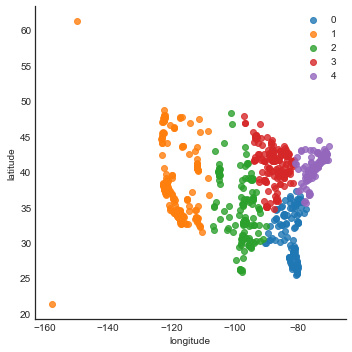

In [24]:
sns.set_style("white")
sns.lmplot(y="latitude", x="longitude", data=df_city_cat, fit_reg=False, hue='Category', legend=False)
plt.legend(loc='upper right')
plt.show()

Orange -> Pacific; Green -> Mountain; Red -> Midwest; Blue -> Southeast; Purple -> Northeast. 
We can see that the U.S. is divided into the 5 big parts as we always come to know: Pacific, Mountain, Midwest, Southeast, and Northeast.

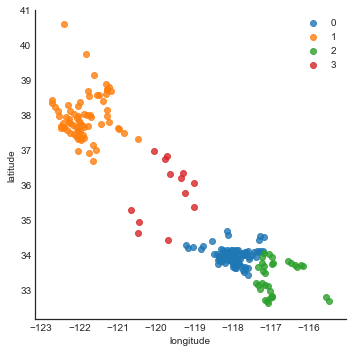

In [25]:
df_cal_city = df_cal[['latitude', 'longitude']]
Z = df_cal_city.values
kmeans_2 = KMeans(n_clusters=4, random_state=0).fit(Z)
label_2 = kmeans_2.labels_
df_cal['Category'] = label_2
df_cal_city_cat = df_cal[['latitude', 'longitude', 'Category']]
sns.set_style("white")
sns.lmplot(y="latitude", x="longitude", data=df_cal_city_cat, fit_reg=False, hue='Category', legend=False)
plt.legend(loc='upper right')
plt.show()

Orange -> Bay Area; Red -> Central Valley; Blue -> L.A. County; Green -> South Coast
So we can see that population of CA are crowded in two areas: Bay Area and the South Coast. This is a very uneven distribution. We then want to analyze why people are all crowded in these two areas but not equally distributed? 

To make it more clear, we draw a pie plot to show the population distribution in 2018.

In [27]:
growth = pd.read_csv("data2.csv")
growth_copy = growth
total = growth['2018 Population'].sum()
growth_copy['percentage'] = (growth['2018 Population'] / total)
total_per = growth.loc[9:]['percentage'].sum()
total_pop = growth.loc[9:]['2018 Population'].sum()
growth_copy.loc[9] = ['Others', total_pop, "NA", total_per]
growth_select = growth_copy[0:10]
growth_select

,NAME,2018 Population,Growth Rate,percentage
0,Los Angeles,10137915,3.17992,0.258291
1,San Diego,3317749,6.87433,0.084529
2,Orange County,3172532,5.13264,0.080829
3,Riverside,2387741,8.42398,0.060834
4,San Bernardino,2140096,4.8264,0.054525
5,Santa Clara,1919402,7.431,0.048902
6,Alameda,1647704,8.85612,0.041980
7,Sacramento,1514460,6.50076,0.038585
8,Contra Costa,1135127,7.81213,0.028920
9,Others,11877291,NA,0.302606


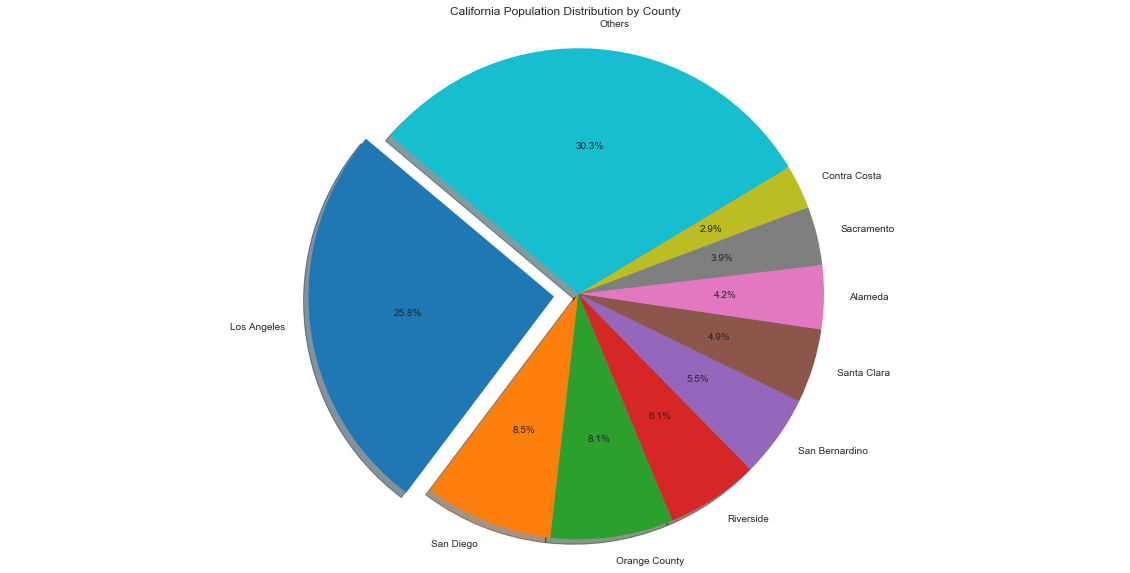

In [28]:
###California Population Distribution Pie Chart
fig, ax = plt.subplots(figsize=(20, 10))
labels = growth_select['NAME']
sizes = growth_select['percentage']
 
# Pie Chart
plt.pie(sizes, labels=labels,
        autopct='%1.1f%%', shadow=True, startangle=140, explode = (0.1,0,0,0,0,0,0,0,0,0))
 
plt.axis('equal')
plt.title("California Population Distribution by County")
plt.show()

As we can see, Los Angeles itself contribute 25.8% of the whole CA population and San Diego, Orange County and Riverside together contribute nearly 25%. Which means these 4 counties contribute about half of the population in CA. We are curious: What makes that uneven distribution in population? 

# 2. Correlation Matrix and the Linear Regression Model 

### Strategy
  In order to better understand how population distributed in the state, we decided to analyze the influential factors which affect the distribution. Instead of population, population density, which is less biased, was chosen. By searching various sources and using different extraction methods, we picked up eight factors: growth rate, birth rate, net migration rate, income level, poverty rate, unemployment rate, number of malls and number of colleges, and used several models to analyze how these influential factors correlate to population distribution. 

### Data Summary

* Population Density: Population/ Area of 58 counties in CA from from Federal Reserve Economic Data (API), California State Association of Counties(XML)

8 Factors:
* Growth Rate from United States Census Bureau(CSV)
* Birth Rate from State of California, Department of Finance(CSV)
* Net Migration/Area, Unemployment Rate from Federal Reserve Economic Data (API)
* Poverty Rate from Public Policy Institute of California(CSV)
* Number of Malls, Number of Colleges(UC system, State Universities, Private colleges) from Wikipedia (HTML)

In order to match the data date and get the accurate model, we chose to use the data in 2015, the year which all of the datasets have the record.

### Data Collection 

In [29]:
###shopping malls###
### the shopping malls 
data = []
result = []
name_of_mall = []
location_of_mall = []
mall = []
url = requests.get('https://en.wikipedia.org/wiki/List_of_shopping_malls_in_California')
soupget = BeautifulSoup(url.content, 'html.parser')# Use beautiful soup parse the data from Wikipedia.
data = soupget.find_all('div', attrs = {'id':"mw-content-text", 'class':"mw-content-ltr"})
result = data[0].find_all('li')
for i in result:
    try:
        name  = i.find_all('a')[0].text
        location = i.find_all('a')[1].text
        name_of_mall.append(name)
        location_of_mall.append(location)
    except:
        continue


mall = pd.DataFrame(name_of_mall,location_of_mall)
mall["name"] = mall.index
mall.columns = ["name","location"]

In [30]:
small = mall.groupby('location').count()
small.index.name = 'county'
small.columns = ['num_malls']


In [31]:
###income level###
# we only extract the income per captia
x = pd.read_html("https://en.wikipedia.org/wiki/List_of_California_locations_by_income")
income = pd.DataFrame(x[1])
income = income.drop(income.columns[1:3], axis=1)
income.columns = ['county','per capita income', 'median household income', 'median family income']
income = income.drop(income.index[0])
income = income.set_index('county')
income= income.stack().str.replace(',','').unstack()
income= income.stack().str.replace('$','').unstack()
income = income.apply(pd.to_numeric)
income['County']=income.index

sincome = income[['per capita income']]

In [32]:
###schools###
# combine the uc schools, state schools, and private schools in CA
data  = []
result = []
college = []
name = []
collegedata = []
url = requests.get("https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_California")
soupget = BeautifulSoup(url.content, 'html.parser')
data = soupget.find_all("table",attrs={"class": "wikitable sortable"})
result = data[0].find_all("td")
for i in result:
    if i.a != None:
        name.append(i.text)
    else:
        continue
name = np.asarray(name)
name = np.split(name, 9)
public_school = pd.DataFrame(name)
public_school.columns = ['a','b','c', 'd']
public_school = public_school.drop('d', 1)
public_school = public_school.drop('b', 1)
public_school.columns = ['Name','County']
public_school['type']='public'

In [33]:
data  = []
result = []
college = []
name = []
collegedata = []
url = requests.get("https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_California")
soupget = BeautifulSoup(url.content, 'html.parser')
data = soupget.find_all("table",attrs={"class": "wikitable sortable"})
result = data[1].find_all("td")
for i in result:
    if i.a != None:
        name.append(i.text)
    else:
        continue
name = np.asarray(name)
name = np.split(name, 23)
state_school = pd.DataFrame(name)
state_school.columns = ['a','b','c', 'd']
state_school = state_school.drop('d', 1)
state_school = state_school.drop('b', 1)
state_school.columns = ['Name','County']
state_school['type']='state school'

In [34]:
data  = []
result = []
college = []
name = []
collegedata = []
url = requests.get("https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_California")
soupget = BeautifulSoup(url.content, 'html.parser')
data = soupget.find_all("table",attrs={"class": "wikitable sortable"})
result = data[2].find_all("td")
for i in result:
    if i.a != None:
        name.append(i.text)
    else:
        continue
        
name = np.asarray(name)
name = np.split(name, 136)
private_school = pd.DataFrame(name)
private_school.columns = ['a','b','c']
private_school = private_school.drop('b', 1)
private_school.columns = ['Name','County']
private_school['type']='private'

In [35]:
frame = [public_school, state_school, private_school]
collegedata = pd.concat(frame)
scollege = collegedata.groupby('County').count()
scollege.index.name = 'county'
scollege = scollege.drop(scollege.columns[1], axis=1)
scollege.columns = ['num_colleges']

In [36]:
###poverty rate###
poverty = pd.read_csv("california poverty.csv")
poverty.columns = ['county','poverty rate','error']
poverty = poverty.set_index('county')
poverty= poverty.stack().str.replace('%','').unstack()
spoverty = poverty['poverty rate'].apply(pd.to_numeric)

In [37]:
###population density###
# population density = 2015 county population/ county area
x = pd.read_html("https://www.indexmundi.com/facts/united-states/quick-facts/california/land-area#table")
area = pd.DataFrame(x[0])
area.head()
area.columns = ['county','Area (sqr mile)']
area = area.set_index('county')
area['population'] = pop_county[[2015]]
area['population density'] = area['population']/area['Area (sqr mile)']
popdensity = area.sort_values(by=['population density'],ascending = False)
pop = popdensity[['population density']]
pop['population density']  = pop['population density']*1000
spop = pop.head(15)

In [38]:
###growth rate###
# the original growth rate data contains the growth rate from 1999 to 2015
# we only extract the 2015 growth rate
growth = pd.read_csv("ca growth rate.csv")
growth.columns.values[0] = 'county'
growth = growth.set_index('county')
growth = growth[['Growth Rate']]

In [39]:
###birth rate###
# the birth rate data contains data from 1990 to 2016
# we only extract the data in 2015
birth = pd.read_excel("P_BirthsReport.xlsx","COUNTY",skiprows = 4)
birth = birth.drop(birth.columns[0], axis=1)
bical = birth.iloc[0,1:28]
countyb = birth.iloc[1:59,0:28]
countyb.columns.values[0] = 'county'
countyb = countyb.set_index('county')
countyp = pop_county.iloc[:,20:47]
countybr = countyb
for i in range(58):
    for j in range(27):
        countybr.iloc[i,j] = countyb.iloc[i,j]/countyp.iloc[i,j]/10
countybr.index = countylist['county']
sbirth = countybr[[2015]]
sbirth.columns.values[0] = 'birth rate'

In [40]:
###unemployment###
# the unempoloyment rate shows the data from 1990 to 2017 for each month
# we take the mean of each year and extract the 2015 umployment rate
df = pd.DataFrame()
for i in range(58):
    countycode = countylist.iloc[i,1]
    county = countylist.iloc[i,0]
    item = pop_search(countycode + 'URN')
    # if no value collected
    if len(item) == 0:
        x = pd.DataFrame(item)
        x = x.append({'county': county, 'date': 'NA','unemployment': 'NA'}, ignore_index = True)
    else:
        search = pd.DataFrame(item)
        search["county"] = county
        search["unemployment"] = search["value"]
        x = search[['county','date','unemployment']] 
    df = df.append(x)
uncounty = df.pivot(index='county', columns='date', values='unemployment').apply(pd.to_numeric)

In [41]:
uncountyf = []
for i in range(1990, 2018):
    filter_no = str(i)
    filter_col = [col for col in uncounty if col.startswith(filter_no)]
    uncounty[filter_no] = uncounty[filter_col].mean(axis=1)
uncountyf = uncounty.drop(uncounty.columns[0:336], axis=1)
sunemp = uncountyf[['2015']]
sunemp.columns.values[0] = 'unemployment rate'

In [42]:
###net migration###
df = pd.DataFrame()

for i in range(58):
    y = i*2+1
    countycode = str(y)
    if y > 9 and y < 100:
        item = pop_search('NETMIGNACS0060' + countycode)
    elif y > 100: 
        item = pop_search('NETMIGNACS006' + countycode)
    else:
        item = pop_search('NETMIGNACS00600' + countycode)
    
    county = countylist.iloc[i,0]
    # if no population value collected
    if len(item) == 0:
        x = pd.DataFrame(item)
        x = x.append({'county': county, 'date': 'NA','migration': 'NA'}, ignore_index = True)
    else:
        search = pd.DataFrame(item)
        search["county"] = county
        search["migration"] = search["value"]
        x = search[['county','date','migration']] 
    df = df.append(x)

In [43]:
micounty = df.pivot(index='county', columns='date', values='migration').apply(pd.to_numeric)
micounty.columns = range(2009,2016)

In [44]:
smigr= micounty[[2015]]
smigr.columns = ['net migration']
smigr['area'] = area[['Area (sqr mile)']]
smigr['net migration rate'] = -smigr['net migration']/smigr['area']
smigr = smigr[['net migration rate']]

In [45]:
### Merge the population density and factors into a large dataset
c = [pop, growth, sbirth,sunemp, smigr, small, sincome, scollege,spoverty]
total = pd.concat(c,axis =1)
stotal = total.loc[pop.index].fillna(0)
stotal

,population density,Growth Rate,birth rate,unemployment rate,net migration rate,num_malls,per capita income,num_colleges,poverty rate
county,,,,,,,,,
San Francisco,18391.380414,8.081875,1.040830,3.608333,197.247706,3.0,49986.0,7.0,13.2
Orange,3992.781158,5.132641,1.191862,4.441667,13.855826,1.0,34416.0,12.0,11.7
Los Angeles,2492.004446,3.179918,1.230566,6.650000,22.075074,6.0,27987.0,39.0,17.1
Alameda,2209.340749,8.856125,1.190754,4.708333,0.860599,1.0,36439.0,10.0,12.0
San Mateo,1701.993711,6.231396,1.184500,3.391667,4.194822,1.0,47198.0,2.0,7.4
Contra Costa,1568.889851,7.812133,1.121675,5.000000,-9.277314,0.0,38770.0,1.0,10.2
Sacramento,1551.505225,6.500762,1.298238,5.966667,-1.545654,1.0,27071.0,4.0,16.5
Santa Clara,1480.586776,7.431000,1.224697,4.150000,9.021781,0.0,42666.0,9.0,9.7
San Diego,782.156976,6.874330,1.336101,5.175000,7.510763,4.0,31043.0,13.0,13.9


# Correlation Matrix

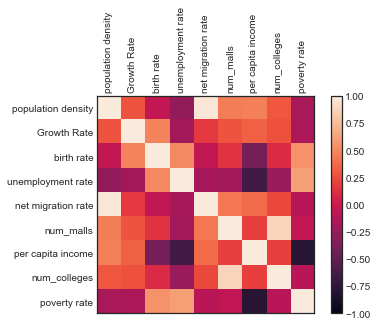

In [46]:
correlation = stotal.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlation, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(stotal.columns,rotation='vertical')
ax.set_yticklabels(stotal.columns)
plt.show()

### Analysis: 
By merging all the cleaned data frames together, we obtained a larger data set which list the population and 8 factors of the 58 counties. Firstly, a correlation matrix was created to observe which factors are highly correlated with the population in order to extract them to build other models. According to the matrix, the net migration is highly correlated to the population density change, with a correlation coefficient of 0.970, and per capita income has a correlation of 0.473,  while the other factors have values around 0.1 - 0.3. 

# Linear Regression Model

In [47]:
y = stotal.loc[:, 'population density']
#X = stotal.drop(columns = ['population density'])
X = stotal.loc[:, ['Growth Rate', 'birth rate', 'unemployment rate','net migration rate', 'num_malls', 'per capita income', 'num_colleges', 'poverty rate']]
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:     population density   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     176.0
Date:                Sun, 18 Mar 2018   Prob (F-statistic):           2.24e-33
Time:                        15:18:17   Log-Likelihood:                -436.63
No. Observations:                  58   AIC:                             891.3
Df Residuals:                      49   BIC:                             909.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -772.0088    870

In [48]:
y2 = stotal.loc[:, 'population density']
X2 = stotal.loc[:, ['net migration rate']]
X22 = sm.add_constant(X2)
est2 = sm.OLS(y, X22)
est22 = est2.fit()
print(est22.summary())

                            OLS Regression Results                            
Dep. Variable:     population density   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     892.8
Date:                Sun, 18 Mar 2018   Prob (F-statistic):           4.24e-36
Time:                        15:18:18   Log-Likelihood:                -452.95
No. Observations:                  58   AIC:                             909.9
Df Residuals:                      56   BIC:                             914.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                354.1615     80

### Analysis:
We also used Linear Regression Model to test which factors influence the population distribution the most and establish a model between population density and the selected variables. The result agrees with the correlation matrix and tell us that the migration population is the main source of the increase of population, compared to birth rate, mortality rate and other factors. The model we found is that 

Population Density = 354.1615 + 91.667 * Net Migration Rate.

This model has an adjusted R^2 value of 0.95, which proves its accuracy and fitness towards the real situation. 

### Suspect:
Apart from that, we also decide to find other factors which definitely affect the population density. For example, from the population graph created by the machine learning and population density mup, we can see the Bay area and Los Angeles area are highly crowded. The common features between those two areas could be analyzed and studied.

# 3. Investigating the Influential factors 

### Strategy
Utilize California counties shapefile and folium maps as background, we plot the rank of specific interested criterions on top of the map to identify influential factors that might impact the population distribution. 

### Data Summary
* districts: shapefile of California counties
* districts_tot: shapefile combined with the potential influential factors

In [49]:
districts = gpd.read_file("CA_Counties/CA_Counties_TIGER2016.shp")

In [50]:
stotal = stotal.reset_index()
stotal = stotal.rename(columns={'county': 'NAME'})
districts_tot = pd.merge(districts, stotal)

In [51]:
dist_pop = districts_tot.iloc[:,0:19]
dist_pop['Rank'] = dist_pop['population density'].rank(method='dense')

First we get the plot of the population density, and we can see that bay area and south california has most densed population (dark red). So we may wonder whaich factors cause these places having such high population density, or what common things do they have to make they attractive to people.   

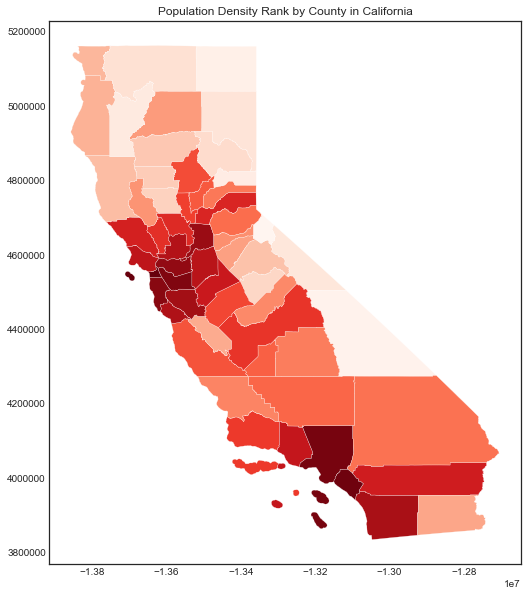

In [52]:
### population density rank
dist_pop.plot(figsize=(10,10), linewidth=0.25, edgecolor='white', column='Rank', cmap = 'Reds')
plt.title("Population Density Rank by County in California")
plt.show()

As we can see from the plot below: The county with high population density usually have lower unemployment rate, especially for the bay area and the souch California. So we can conclude that the low unemployment rate maybe a important factor to attract the people to these counties. 

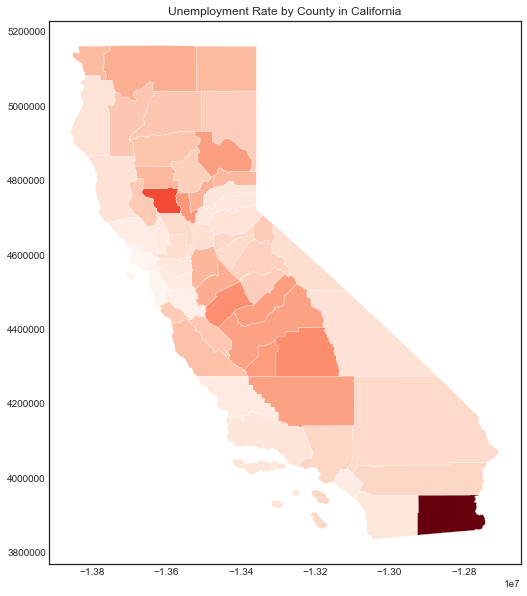

In [53]:
districts_tot.plot(figsize=(10,10), linewidth=0.25, edgecolor='white', column='unemployment rate', cmap = 'Reds')
plt.title("Unemployment Rate by County in California")
plt.show()

In [54]:
plotly.tools.set_credentials_file('zhenhansi', 'f1FIXZMElqLq2olEQldG')
py.sign_in('zhenhansi', 'f1FIXZMElqLq2olEQldG')

Next we will analyze how income level affect the population density. We discover that the counties having high population density generally have higher average income than other counties, but the differences are not very significant. So we conclude that income level have some effects on population, but not strongly. 

In [55]:
trace2 = {
      "lat": districts_tot['INTPTLAT'], 
      "lon": districts_tot['INTPTLON'] , 
      "marker": {
        "size": districts_tot['per capita income']*0.002, 
        "sizeref": 4
      }, 
      "mode": "markers", 
      "name": "B",  
      "type": "scattermapbox", 
      "uid": "469a5a"
    }
data2 = go.Data([trace2])
layout = {
      "autosize": True, 
      "height": 511, 
      "hovermode": "closest", 
      "mapbox": {
        "bearing": 0, 
        "center": {
          "lat": 35.3116418698, 
          "lon": -118.441428557
        }, 
        "pitch": 0, 
        "zoom": 5.10790759747
      }, 
      "title": "Income level by County in  California", 
      "width": 910
    }
fig = go.Figure(data=data2, layout=layout)
py.iplot(fig)

We then analyze how number of malls in a county affect the population density. Since we believe more malls in a county represents more urbanize a county is. The result shows that counties with higher population density usually have more malls. But we hardly say it's because these malls attract people or more people attract merchants to build malls, or both. 

In [56]:
trace3 = {
      "lat": districts_tot['INTPTLAT'], 
      "lon": districts_tot['INTPTLON'] , 
      "marker": {
        "size": districts_tot['num_malls']*20, 
        "sizeref": 4
      }, 
      "mode": "markers", 
      "name": "B",  
      "type": "scattermapbox", 
      "uid": "469a5a"
    }
data3 = go.Data([trace3])
layout = {
      "autosize": True, 
      "height": 511, 
      "hovermode": "closest", 
      "mapbox": {
        "bearing": 0, 
        "center": {
          "lat": 35.3116418698, 
          "lon": -118.441428557
        }, 
        "pitch": 0, 
        "zoom": 5.10790759747
      }, 
      "title": "Number of malls by County in  California", 
      "width": 910
    }
fig = go.Figure(data=data3, layout=layout)
py.iplot(fig)

We believe numbers of schools also can be a factor which can attract more people thus we visualize all kinds of schools in California and find out that high populated area have much more schools than other schools. So we can conclude that schools are also a main factor attracting students, especially for international students like us. 

In [57]:
trace4 = {
      "lat": districts_tot['INTPTLAT'], 
      "lon": districts_tot['INTPTLON'] , 
      "marker": {
        "size": districts_tot['num_colleges']*15, 
        "sizeref": 4
      }, 
      "mode": "markers", 
      "name": "B",  
      "type": "scattermapbox", 
      "uid": "469a5a"
    }
data4 = go.Data([trace4])
layout = {
      "autosize": True, 
      "height": 511, 
      "hovermode": "closest", 
      "mapbox": {
        "bearing": 0, 
        "center": {
          "lat": 35.3116418698, 
          "lon": -118.441428557
        }, 
        "pitch": 0, 
        "zoom": 5.10790759747
      }, 
      "title": "Number of colleges by County in  California", 
      "width": 910
    }
fig = go.Figure(data=data4, layout=layout)
py.iplot(fig)

We are curious about whether population density is related to the birth rate. But as we draw the plot below we can conclude that population has no correlation with birth rate. Its mainly correlated to the migration rate, as we get the same result in the regression model.

In [ ]:
trace5 = {
      "lat": districts_tot['INTPTLAT'], 
      "lon": districts_tot['INTPTLON'] , 
      "marker": {
        "size": districts_tot['birth rate']*100, 
        "sizeref": 4
      }, 
      "mode": "markers", 
      "name": "B",  
      "type": "scattermapbox", 
      "uid": "469a5a"
    }
data5 = go.Data([trace4])
layout = {
      "autosize": True, 
      "height": 511, 
      "hovermode": "closest", 
      "mapbox": {
        "bearing": 0, 
        "center": {
          "lat": 35.3116418698, 
          "lon": -118.441428557
        }, 
        "pitch": 0, 
        "zoom": 5.10790759747
      }, 
      "title": "Birth rate by County in  California", 
      "width": 910
    }
fig = go.Figure(data=data5, layout=layout)
py.iplot(fig)

At last we analyze how poverty rate affects the population. And we get the results below that these two are not correlated. 

In [ ]:
trace6 = {
      "lat": districts_tot['INTPTLAT'], 
      "lon": districts_tot['INTPTLON'] , 
      "marker": {
        "size": districts_tot['poverty rate']*50, 
        "sizeref": 4
      }, 
      "mode": "markers", 
      "name": "B",  
      "type": "scattermapbox", 
      "uid": "469a5a"
    }
data6 = go.Data([trace4])
layout = {
      "autosize": True, 
      "height": 511, 
      "hovermode": "closest", 
      "mapbox": {
        "bearing": 0, 
        "center": {
          "lat": 35.3116418698, 
          "lon": -118.441428557
        }, 
        "pitch": 0, 
        "zoom": 5.10790759747
      }, 
      "title": "Number of colleges by County in  California", 
      "width": 910
    }
fig = go.Figure(data=data6, layout=layout)
py.iplot(fig)

# Conclusion

•	From the Sankey diagram, we show the migration that where do people come to California and where do Californians   go.

•	From the Google Trend, we show the "Google Trend Overtime for 'Immigration' in California" and "Population Growth Rate of California Overtime."

•	From the time series, we establish the model to predict the population in each county in the future 10 years. 

•	From the kmean algorithm machine learning, we show the population distribution by dividing both United States and California into parts by population

•	From the pie chart, we show the population distribution for major cities in California, and notice that Los Angeles has the largest population in the state.

•	From the correlation matrix, we analyze which factors are correlated with the population mostly that includes growth rate, birth rate, net migration rate, unemployment rate, income per capita, poverty rate, number of malls and number of colleges. 

•	From the linear regression model, we test which factors influence the population distribution the most and establish a model between population density and variables. 

•	From the word cloud, we know the Californian’s perspectives that which topics people care and “population” is also very hot. 


# Potential errors and improvements

•	There are some improvements in our data that some variables might be omitted, and other factors might influence the population that we did not consider. 

•	Through diagnosis, we consider that there might be some ways to improve our time series model more precisely. 

•	The data is not up-to-date that the government does not have a comprehensive database.

•	We can also improve the linear regression model in to a generalized linear regression model.


